# Appendix: Testing the Interaction Values

This Jupyter notebook contains supplementary material for the research paper titled "Introduction to Interaction Values in Cooperative Game Theory: An innovative Shapley-Based Approach, with Marketing Case Study". 

### Importing the needed libraries:

- **"pandas"**: used for handling the dataset.
- **"numPy", "math", "itertools"**: used to handle mathematical operations.
- **"seaborn", "matplotlib"**: used to plot the Interaction Matrix.
- **"deap"**: Used to set up the Genetic Algorithm needed for the optimisation task

Make sure every module listed is installed on your machine before running the code.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from math import factorial
from itertools import combinations
from deap import base, creator, tools, algorithms

### Dataset loading

In [5]:
# Load the dataset
file_path = 'data.xlsx'
data = pd.read_excel(file_path)

data.head()

/Users/chakir/Library/Python/3.9/lib/python/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Consumer_ID,Existing_customer,Relation_length,CLV,Firm_banner,Email_group,Banner_no_click,Banner_click,SEA_product_click,SEA_brand_click,Price_comp_click,Email_no_click,Email_click,Direct_visit,Social_visit,First_channel,Last_channel,Amount_touchpoints,Flyer_region,Purchase
0,1,0,0,0.000000,1,0,0,0,0,0,1,0,0,3,1,Social_visit,Direct_visit,6,1,0
1,2,1,16,565.235935,1,0,0,0,0,0,1,0,0,3,0,Price_comp_click,Direct_visit,5,1,1
2,3,1,9,2430.037780,0,1,1,0,0,0,0,0,0,3,1,Social_visit,Direct_visit,6,0,1
3,4,1,9,1423.361957,0,0,1,0,0,0,1,0,0,3,2,Direct_visit,Social_visit,7,0,0
4,5,1,35,2505.091038,1,1,2,1,0,0,0,0,0,3,3,Social_visit,Direct_visit,11,0,1


### Selecting the useful columns for the study

Next, the eleven columns useful for the study mentioned in the paper are selected from the dataset.

Each cell is converted to a binary input explaining whether the consumer interacted with the channel or not.

Then, the repeated paths in the dataset are aggregated by taking the sum of purchases.

The output is a dataset with unique rows representing consumers' paths and the sum of purchases resulting from each path.

This new dataset will be used to compute the Shapley and Interaction values as defined in the paper.

In [6]:
# Identifying the columns representing the marketing channels and the 'Purchase' column
marketing_channels = [
    "Firm_banner", "Email_group", "Banner_no_click", "Banner_click",
    "SEA_product_click", "SEA_brand_click", "Price_comp_click", "Email_no_click",
    "Email_click", "Direct_visit", "Social_visit"
]
purchase_column = "Purchase"

# Selecting only the relevant columns
selected_data = data[marketing_channels + [purchase_column]]

# Converting all inputs in the cells to 0s and 1s (if an input is bigger than 1, change it to 1)
selected_data = selected_data.applymap(lambda x: 1 if x > 0 else 0)

# Group by the marketing channels and sum the purchases
grouped_data = selected_data.groupby(marketing_channels).sum().reset_index()

grouped_data.head()


/var/folders/9k/jzxy5b0j6zjcx9kq2ns60_f80000gn/T/ipykernel_18938/4113750348.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  selected_data = selected_data.applymap(lambda x: 1 if x > 0 else 0)


,Firm_banner,Email_group,Banner_no_click,Banner_click,SEA_product_click,SEA_brand_click,Price_comp_click,Email_no_click,Email_click,Direct_visit,Social_visit,Purchase
0,0,0,0,0,0,0,0,0,0,1,0,15
1,0,0,0,0,0,0,0,0,0,1,1,106
2,0,0,0,0,0,0,1,0,0,0,0,2
3,0,0,0,0,0,0,1,0,0,0,1,23
4,0,0,0,0,0,0,1,0,0,1,0,6


### Occuurrences of channels in the dataset

A checking of the occurrences of the previously mentioned channels is done to check the presence of each one in the dataset, lower values could affect the computation of Shapley and Interaction Values for a channel.

In [7]:
# Compute the occurrence of each channel by counting non-zero values in each column
channel_occurrences = (grouped_data.iloc[:, :-1] != 0).sum()

channel_occurrences

Firm_banner          482
Email_group          618
Banner_no_click      475
Banner_click         323
SEA_product_click    397
SEA_brand_click      440
Price_comp_click     408
Email_no_click       293
Email_click          242
Direct_visit         510
Social_visit         484
dtype: int64

### Shapley Values

Next, a dictionary is created having as keys each combination of channels present in the dataset and the sum of purchases of respective coalitions as values.

In [8]:
# Dictionary to store the total conversions for each combination of channels
coalitions_dict = {}

for index, row in grouped_data.iterrows():
    # Identify the channels in the current coalition
    coalition = {channel for channel in marketing_channels if row[channel] == 1}

    # The total number of conversions for this coalition
    total_conversions = row['Purchase']  # Replace 'Purchase' with your actual column name if different

    # Add to the dictionary
    coalitions_dict[frozenset(coalition)] = total_conversions


Now, a function computing Shapley Values for each marketing channel is defined. The output is a dictionary containing each marketing channel and its corresponfing Shapley Value.

The formula for the Shaply Values is the following:

$\phi_i(v) = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} \left(v(S \cup \{i\}) - v(S)\right)$

In order to get meaningful values, considering the scarcity of the dataset, only the cases in which both sets $S \cup \{i\}$ and $S$ are present in the dictionary are considered.

In [9]:
def shapley(coalitions_dict, channel_columns):
    # Initialize Shapley values for each channel
    shapley_values_dict = {channel: 0 for channel in channel_columns}
    n = len(channel_columns)

    # Function to check if the coalition is in the coalitions dicttionary
    def is_coalition_present(coalition):
        return frozenset(coalition) in coalitions_dict

    # Function to get the total conversions for a given coalition
    def get_total_conversions(coalition):
        return coalitions_dict[frozenset(coalition)]

    # Iterattion over each channel
    for channel in channel_columns:
        checked = []
        for S in range(1, n):
            for subset_tuple in combinations(channel_columns, S):
                subset = set(subset_tuple)  # Convert tuple to set to use frozensets for checking in the dictionary
                if frozenset(subset) not in checked:
                    if channel not in subset:
                        checked.append(frozenset(subset))
                        subset_with_channel = subset | {channel}  # Use set union to add the channel
                        # Skip if either subset or subset with channel is not present in coalitions_dict
                        if is_coalition_present(frozenset(subset)) and is_coalition_present(frozenset(subset_with_channel)):
                            subset_value = get_total_conversions(frozenset(subset))
                            subset_with_channel_value = get_total_conversions(frozenset(subset_with_channel))
                            weight = (factorial(S) * factorial(n - S - 1)) / factorial(n)
                            marginal_contribution = subset_with_channel_value - subset_value
                            shapley_values_dict[channel] += marginal_contribution * weight

    return shapley_values_dict


Now, Shapley Values are computed for each marketing channel.

In [10]:
shapley_values = shapley(coalitions_dict, marketing_channels)
shapley_values

{'Firm_banner': 9.404292929292936,
 'Email_group': -2.072871572871573,
 'Banner_no_click': 4.323304473304472,
 'Banner_click': -10.299062049062051,
 'SEA_product_click': -0.7542207792207807,
 'SEA_brand_click': 3.616702741702742,
 'Price_comp_click': -0.3228354978354988,
 'Email_no_click': 0.5646464646464646,
 'Email_click': -2.904112554112554,
 'Direct_visit': 5.930050505050503,
 'Social_visit': 7.116702741702745}

### Interaction Values

Using a similar approach, a function computing Interaction Values for each pair of channels is defined. The output is a dictionary containing each pair of marketing channels and its corresponfing Interaction Value.

The formula introduced for the Interaction Values is the following:

$\phi_{ij}(v) = \sum_{S \subseteq N \setminus \{i,j\}} \frac{(|S|+1)!(|N|-|S|-2)!}{|N|!} \left(v(S \cup \{i,j\}) - v(S \cup \{i\})\right)$

Similarly, in order to get meaningful values, considering the scarcity of the dataset, only the cases in which both sets $S \cup \{i,j\}$ and $S \cup \{i\}$ are present in the dictionary are considered.

In [11]:
def interaction_values(coalitions_dict, channel_columns):

    # Initialize Interaction Values for each pair of channels
    interaction_values_dict = {(i, j): 0 for i in channel_columns for j in channel_columns if i != j}
    n = len(channel_columns)

    # Function to check if the coalition is in the coalitions_dict
    def is_coalition_present(coalition):
        return frozenset(coalition) in coalitions_dict

    # Function to get the total conversions for a given coalition
    def get_total_conversions(coalition):
        return coalitions_dict.get(frozenset(coalition), 0)

    # Iterate over each pair of channels
    for i in channel_columns:
        for j in channel_columns:
            if i != j:
                checked = []
                for S in range(1, n):
                    for subset_tuple in combinations(channel_columns, S):
                        subset = set(subset_tuple)  # Convert tuple to set to use frozensets for checking in the dictionary
                        if frozenset(subset) not in checked:
                            checked.append(frozenset(subset))
                            if not(i in subset or j in subset):
                                subset_with_i = subset | {i}
                                subset_with_i_j = subset | {i, j}
                                # Skip if the required subsets are not present in coalitions_dict
                                if is_coalition_present(subset_with_i) and is_coalition_present(subset_with_i_j):
                                    subset_with_i_value = get_total_conversions(subset_with_i)
                                    subset_with_i_j_value = get_total_conversions(subset_with_i_j)
                                    weight = factorial(S + 1) * factorial(n - S - 2) / factorial(n)
                                    marginal_contribution = subset_with_i_j_value - subset_with_i_value
                                    interaction_values_dict[(i, j)] += marginal_contribution * weight
            

    return interaction_values_dict


Now, Interaction Values are computed for each pair of marketing channel.

In [12]:
interaction_values = interaction_values(coalitions_dict, marketing_channels)

### Interaction Matrix

A function constructing the Interaction Matrix is defined using the Shapley (in the diagonal) and Interaction Values (off-diagonal values of the matrix) computed in the previous step.

The Interaction Matrix is defined as follows:

$$
M(v) = 
\begin{bmatrix}
    \phi_1(v) & \phi_{1,2}(v) & \cdots & \phi_{1,n}(v) \\
    \phi_{2,1}(v) & \phi_2(v) & \cdots & \phi_{2,n}(v) \\
    \vdots & \vdots & \ddots & \vdots \\
    \phi_{n,1}(v) & \phi_{n,2}(v) & \cdots & \phi_n(v)
\end{bmatrix}
$$

In [13]:
def interaction_matrix(shapley_values, interaction_values, channel_columns):
    n = len(channel_columns)
    interaction_matrix = np.zeros((n, n))

    # Fill diagonal with individual Shapley values
    for i, channel in enumerate(channel_columns):
        interaction_matrix[i, i] = shapley_values[channel]

    # Fill off-diagonal with pairwise Shapley values
    for i, channel_i in enumerate(channel_columns):
        for j, channel_j in enumerate(channel_columns):
            if i != j:
                interaction_matrix[i, j] = interaction_values[channel_i, channel_j]

    return interaction_matrix


Now, we compute the Interaction Matrix.

In [14]:
interaction_matrix = interaction_matrix(shapley_values, interaction_values, marketing_channels)

A heatmap representing the Interaction Matrix is plotted.

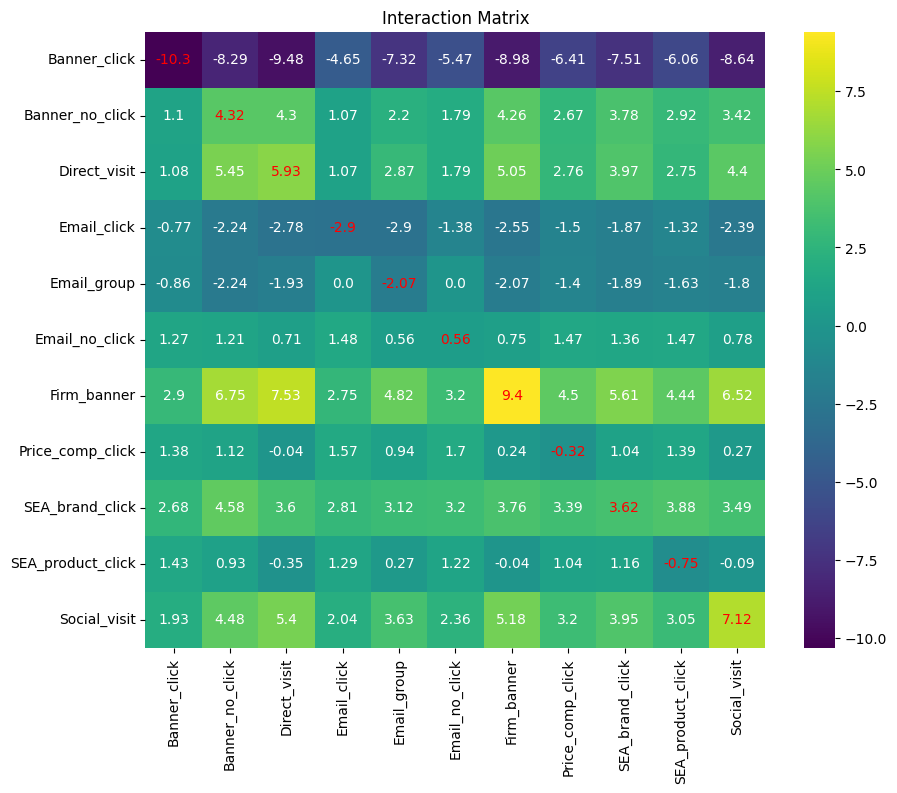

In [15]:
# Extract unique channels
channels = set()
for pair in interaction_values.keys():
    channels.update(pair)
channels = sorted(list(channels))

# Create an empty DataFrame representing the matrix
interaction_matrix_df = pd.DataFrame(index=channels, columns=channels, data=0.0)

# Populate the DataFrame with values from the dictionary
for (channel1, channel2), value in interaction_values.items():
    # For asymmetric interactions, populate only one direction
    interaction_matrix_df.at[channel1, channel2] = value

# Populate diagonal with Shapley values
for channel, value in shapley_values.items():
    interaction_matrix_df.at[channel, channel] = value

plt.figure(figsize=(10, 8))
ax = sns.heatmap(interaction_matrix_df.T, cmap='viridis', annot=False)

# Annotate non-diagonal elements
for i in range(interaction_matrix_df.shape[0]):
    for j in range(interaction_matrix_df.shape[1]):
        if i != j:
            text = ax.text(j + 0.5, i + 0.5, round(interaction_matrix_df.iloc[j, i], 2),
                           ha="center", va="center", color="w")

# Annotate diagonal elements in red
for i in range(interaction_matrix_df.shape[0]):
    text = ax.text(i + 0.5, i + 0.5, round(interaction_matrix_df.iloc[i, i], 2),
                   ha="center", va="center", color="red")

plt.savefig("plot.png")

plt.title("Interaction Matrix")
plt.show()

### Optimisation Task

In this section, we set the budget constraint and the cost of each channel, then we set up the Genetic Algorithm with the specifications mentioned in the paper.

In [16]:
# Define the channel costs and budget
channel_costs = {
    'Firm_banner': 146, 
    'Email_group': 84, 
    'Banner_no_click': 100,
    'Banner_click': 98, 
    'SEA_product_click': 102, 
    'SEA_brand_click': 90, 
    'Price_comp_click': 51, 
    'Email_no_click': 94, 
    'Email_click': 90, 
    'Direct_visit': 72, 
    'Social_visit': 135
}

budget = 500

In the next section, the Genetic Algorithm using only Shapley Values is set up, and the optimal coalition of marketing channels is predicted.

In [17]:
random.seed(123)

# Setup for Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(marketing_channels))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval(individual):
    # Sum of Shapley Values for each channel in the individual
    total_value = sum(interaction_matrix[i, i] * individual[i] for i in range(len(marketing_channels)))
    
    # Calculate total cost
    total_cost = sum(channel_costs[marketing_channels[i]] * individual[i] for i in range(len(marketing_channels)))

    # Check if the total cost is within the budget
    if total_cost > budget:
        return -1,  # Penalty for exceeding budget

    return total_value,

# Genetic operators
toolbox.register("evaluate", eval)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Creating the population
population = toolbox.population(n=100)

# Running the genetic algorithm
ngen = 50
result = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=ngen, verbose=False)

# Extracting the best solution
best_ind = tools.selBest(population, k=1)[0]
best_channels = [marketing_channels[i] for i in range(len(best_ind)) if best_ind[i] == 1]
best_value = eval(best_ind)[0]

print("Best Subset of Channels:", best_channels)
print("Best Value:", best_value)

Best Subset of Channels: ['Firm_banner', 'Banner_no_click', 'Direct_visit', 'Social_visit']
Best Value: 26.774350649350655


Next, the Genetic Algorithm using both Shapley and Interaction Values is set up, and the optimal coalition of marketing channels is predicted.

In [18]:
random.seed(123)

# Setup for Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(marketing_channels))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval(individual):
    # Sum of Shapley Values for each channel in the individual
    diagonal_sum = sum(interaction_matrix[i, i] * individual[i] for i in range(len(marketing_channels)))

    # Sum of Interaction Values for all pairs of channels in the individual
    interaction_sum = sum(interaction_matrix[i, j] * individual[i] * individual[j] for i in range(len(marketing_channels)) for j in range(len(marketing_channels)) if i != j)

    # Total value is the sum of diagonal values and interaction values
    total_value = diagonal_sum + 0.3 * interaction_sum

    # Calculate total cost
    total_cost = sum(channel_costs[marketing_channels[i]] * individual[i] for i in range(len(marketing_channels)))

    # Check if the total cost is within the budget
    if total_cost > budget:
        return -1,  # Penalty for exceeding budget

    return total_value,


# Genetic operators
toolbox.register("evaluate", eval)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Creating the population
population = toolbox.population(n=100)

# Running the genetic algorithm
ngen = 50
result = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=ngen, verbose=False)

# Extracting the best solution
best_ind = tools.selBest(population, k=1)[0]
best_channels = [marketing_channels[i] for i in range(len(best_ind)) if best_ind[i] == 1]
best_value = eval(best_ind)[0]

print("Best Subset of Channels:", best_channels)
print("Best Value:", best_value)


Best Subset of Channels: ['Firm_banner', 'SEA_brand_click', 'Price_comp_click', 'Direct_visit', 'Social_visit']
Best Value: 47.88991341991341


/Users/chakir/Library/Python/3.9/lib/python/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/chakir/Library/Python/3.9/lib/python/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Last, a function calculating the total number of conversions for a specific coalition of channels is created. This function is used to get the number of conversions from each of the two outputs for comparative purposes.

In [19]:
def conversions(df, coalition):
    checked = []
    purchases = 0
    for S in range(1, len(coalition)):
        for subset in combinations(coalition, S):
            subset = frozenset(subset)
            if subset not in checked:
                checked.append(subset)
                if subset in df:
                    purchases += df[subset]
    return purchases

In [20]:
conversions(coalitions_dict, ['Firm_banner', 'Banner_no_click', 'Direct_visit', 'Social_visit'])

688

In [21]:
conversions(coalitions_dict, ['Firm_banner', 'SEA_brand_click', 'Price_comp_click', 'Direct_visit', 'Social_visit'])

1002